In [1]:
import tensorflow as tf
from time import time
from tensorflow.keras import metrics
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from datasets import load_dataset
from tabulate import tabulate

In [2]:
# load our own package
from retvec.utils import tf_cap_memory
from retvec import RetVec

In [3]:
# cap tf
tf_cap_memory()

In [4]:
MAX_LEN = 128
BATCH_SIZE = 128

In [5]:
dataset = load_dataset('ag_news')

Using custom data configuration default
Reusing dataset ag_news (C:\Users\elie\.cache\huggingface\datasets\ag_news\default\0.0.0\bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548)
100%|██████████| 2/2 [00:00<00:00, 500.07it/s]


In [6]:
NUM_LABELS = 4
x_train = tf.constant(dataset['train']['text'], dtype=tf.string)
y_train = tf.one_hot(dataset['train']['label'], NUM_LABELS)
x_test = tf.constant(dataset['test']['text'], dtype=tf.string)
y_test = tf.one_hot(dataset['test']['label'], NUM_LABELS)

# BATCH SIZE
m_train = len(x_train) // BATCH_SIZE
x_train = x_train[:m_train * BATCH_SIZE]
y_train = y_train[:m_train * BATCH_SIZE]

m_test = len(x_test) // BATCH_SIZE
x_test = x_test[:m_test * BATCH_SIZE]
y_test = y_test[:m_test * BATCH_SIZE]

In [7]:
import tensorflow as tf
import numpy as np


import numpy as np
import tensorflow as tf


class FourierFeatureProjection2(tf.keras.layers.Layer):

    def __init__(self, gaussian_projection: int, gaussian_scale: float = 1.0, **kwargs):
        """
        Fourier Feature Projection layer from the paper:
        [Fourier Features Let Networks Learn High Frequency Functions in Low Dimensional Domains](https://arxiv.org/abs/2006.10739)
        Add this layer immediately after the input layer.
        Args:
            gaussian_projection: Projection dimension for the gaussian kernel in fourier feature
                projection layer. Can be negative or positive integer.
                If <=0, uses identity matrix (basic projection) without gaussian kernel.
                If >=1, uses gaussian projection matrix of specified dim.
            gaussian_scale: Scale of the gaussian kernel in fourier feature projection layer.
                Note: If the scale is too small, convergence will slow down and obtain poor results.
                If the scale is too large (>50), convergence will be fast but results will be grainy.
                Try grid search for scales in the range [10 - 50].
        """
        super().__init__(**kwargs)

        if 'dtype' in kwargs:
            self._kernel_dtype = kwargs['dtype']
        else:
            self._kernel_dtype = None

        gaussian_projection = int(gaussian_projection)
        gaussian_scale = float(gaussian_scale)

        self.gauss_proj = gaussian_projection
        self.gauss_scale = gaussian_scale

    def build(self, input_shape):
        # assume channel dim is always at last location
        input_dim = input_shape[-1]

        if self.gauss_proj <= 0:
            # Assume basic projection
            self.proj_kernel = tf.keras.layers.Dense(input_dim, use_bias=False, trainable=False,
                                                     kernel_initializer='identity', dtype=self._kernel_dtype)

        else:
            initializer = tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=self.gauss_scale)
            self.proj_kernel = tf.keras.layers.Dense(self.gauss_proj, use_bias=False, trainable=False,
                                                     kernel_initializer=initializer, dtype=self._kernel_dtype)

        self.built = True

    def call(self, inputs, **kwargs):
        x_proj = 2.0 * np.pi * inputs
        x_proj = self.proj_kernel(x_proj)

        x_proj_sin = tf.sin(x_proj)
        # x_proj_sin = tf.keras.layers.Activation('sigmoid')(x_proj)
        # x_proj_cos = tf.cos(x_proj)
        x_proj_cos = tf.keras.layers.Activation('softsign')(x_proj)
        output = tf.concat([x_proj_sin, x_proj_cos], axis=-1)
        return output

    def get_config(self):
        config = {
            'gaussian_projection': self.gauss_proj,
            'gaussian_scale': self.gauss_scale
        }
        base_config = super().get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [14]:
from retvec.projection import FourierFeatureProjection

def get_model(dim, depth, model, max_len, num_labels, trainable, fourier=False):
     print("Model", model)
     print("Trainable", trainable)
     inputs = layers.Input(shape=(1, ), name="token", dtype=tf.string)
     x = RetVec(max_len=max_len, model=model, trainable=trainable)(inputs)
     if fourier:
          x = FourierFeatureProjection(gaussian_projection_dim=256, 
                                       gaussian_scale=10,
                                       activations=['sin', 'softsign'])(x)

     # seems to help with mixnet not LSTM
     # x = x + 1
     # x = x // 2
    
     x = layers.BatchNormalization()(x)
     # x = layers.LayerNormalization()(x)
     # for _ in range(depth):
     #      x = MixerBlock(max_len=max_len, encoder_dim=dim, hidden_dim=dim, 
     #                     activation='softsign')(x) 
     # x = layers.GlobalAveragePooling1D()(x)
     
     for _ in range(depth - 1):
          x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(dim, return_sequences=True))(x)
     x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(dim))(x)
     outputs = layers.Dense(num_labels, activation='softmax')(x)
     test_model = tf.keras.Model(inputs, outputs)
     test_model.summary()
     return test_model

In [16]:
EPOCHS = 2
# mix
# DIMS = 256  # same size as the tokens
# DEPTH = 6

# LSTM
DIMS = 64
DEPTH = 1

MODEL = '../tmp/cnn_auto_model/'
MODEL = '../tmp/mix_auto_model'
MODEL = '../tmp/bert_auto_model'
#MODEL  = None
EMBEDDING_TRAINABLE = False

test_model = get_model(DIMS, DEPTH, None, MAX_LEN, NUM_LABELS, EMBEDDING_TRAINABLE, fourier=True)
test_model.compile('adam', loss='categorical_crossentropy', metrics=['acc'])
neural_history = test_model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE , validation_data=(x_test, y_test))

Model None
Trainable False
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 token (InputLayer)          [(None, 1)]               0         
                                                                 
 ret_vec_3 (RetVec)          (None, 128, 256)          0         
                                                                 
 fourier_feature_projection_  (None, 128, 512)         65536     
 3 (FourierFeatureProjection                                     
 )                                                               
                                                                 
 batch_normalization_3 (Batc  (None, 128, 512)         2048      
 hNormalization)                                                 
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              295424    
 nal)                           

In [ ]:
# Neural 2
Epoch 1/2
937/937 [==============================] - 23s 23ms/step - loss: 0.4994 - acc: 0.8123 - val_loss: 0.3630 - val_acc: 0.8706
Epoch 2/2
937/937 [==============================] - 21s 22ms/step - loss: 0.2691 - acc: 0.9061 - val_loss: 0.3157 - val_acc: 0.8909


# 256, 10
937/937 [==============================] - 22s 22ms/step - loss: 0.5332 - acc: 0.7979 - val_loss: 0.3890 - val_acc: 0.8607
Epoch 2/2
937/937 [==============================] - 20s 21ms/step - loss: 0.2939 - acc: 0.8965 - val_loss: 0.3249 - val_acc: 0.8889

In [ ]:
test_model = get_model(DIMS, DEPTH, None, MAX_LEN, NUM_LABELS, EMBEDDING_TRAINABLE, fourier=False)
test_model.compile('adam', loss='categorical_crossentropy', metrics=['acc'])
base_history = test_model.fit(x_train, y_train, steps_per_epoch=200, epochs=EPOCHS, batch_size=BATCH_SIZE , validation_data=(x_test, y_test))

Model None
Trainable False
Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 token (InputLayer)          [(None, 1)]               0         
                                                                 
 ret_vec_10 (RetVec)         (None, 128, 256)          0         
                                                                 
 batch_normalization_10 (Bat  (None, 128, 256)         1024      
 chNormalization)                                                
                                                                 
 bidirectional_10 (Bidirecti  (None, 128)              164352    
 onal)                                                           
                                                                 
 dense_10 (Dense)            (None, 4)                 516       
                                                                 
Total params: 165,892
Trainable

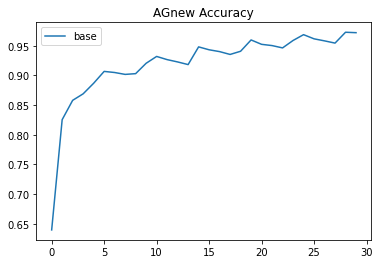

In [ ]:

plt.plot(neural_history.history['acc'])
plt.legend(['base', 'neural'])
plt.title(f'AGnew Accuracy')
plt.show()

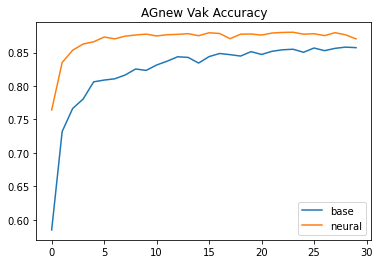

In [ ]:
plt.plot(base_history.history['val_acc'])
plt.plot(neural_history.history['val_acc'])
plt.legend(['base', 'neural'])
plt.title(f'AGnew Vak Accuracy')
plt.show()

In [ ]:
# 128, 10
937/937 [==============================] - 22s 21ms/step - loss: 0.6099 - acc: 0.7624 - val_loss: 0.4036 - val_acc: 0.8561
Epoch 2/2
937/937 [==============================] - 19s 20ms/step - loss: 0.3350 - acc: 0.8817 - val_loss: 0.3717 -

# 256, 10
937/937 [==============================] - 22s 22ms/step - loss: 0.5332 - acc: 0.7979 - val_loss: 0.3890 - val_acc: 0.8607
Epoch 2/2
937/937 [==============================] - 20s 21ms/step - loss: 0.2939 - acc: 0.8965 - val_loss: 0.3249 - val_acc: 0.8889

# 256, 20
Epoch 1/2
937/937 [==============================] - 22s 22ms/step - loss: 0.5309 - acc: 0.7988 - val_loss: 0.3698 - val_acc: 0.8663
Epoch 2/2
937/937 [==============================] - 20s 21ms/step - loss: 0.2915 - acc: 0.8978 - val_loss: 0.3327 - val_acc: 0.8825


#base
Epoch 1/2
937/937 [==============================] - 22s 22ms/step - loss: 0.7366 - acc: 0.7064 - val_loss: 0.5273 - val_acc: 0.8075
Epoch 2/2
937/937 [==============================] - 20s 21ms/step - loss: 0.4650 - acc: 0.8316 - val_loss: 0.4625 - val_acc: 0.8322


SyntaxError: invalid syntax (Temp/ipykernel_14460/794826689.py, line 2)

In [ ]:
print(MODEL)
headers = list(history.history.keys())
rows = []
for i in range(EPOCHS):
    rows.append([i] + [history.history[k][i] for k in headers])
print(tabulate(rows, headers=headers))

../tmp/mix_auto_model
        loss       acc    val_loss    val_acc
--  --------  --------  ----------  ---------
 0  0.596855  0.770611    0.430783   0.845074
 1  0.358326  0.872707    0.473056   0.829846
 2  0.302085  0.892468    0.384674   0.865598
 3  0.269414  0.904516    0.335337   0.882283
 4  0.24535   0.912237    0.334186   0.880694
 5  0.221848  0.921108    0.344441   0.881091
 6  0.206619  0.927411    0.331059   0.884666
 7  0.192452  0.931205    0.330382   0.887712
 8  0.179206  0.935949    0.330971   0.889566
 9  0.166754  0.940126    0.340732   0.886917


../tmp/mix_auto_model
        loss       acc    val_loss    val_acc
--  --------  --------  ----------  ---------
 0  0.596855  0.770611    0.430783   0.845074
 1  0.358326  0.872707    0.473056   0.829846
 2  0.302085  0.892468    0.384674   0.865598
 3  0.269414  0.904516    0.335337   0.882283
 4  0.24535   0.912237    0.334186   0.880694
 5  0.221848  0.921108    0.344441   0.881091
 6  0.206619  0.927411    0.331059   0.884666
 7  0.192452  0.931205    0.330382   0.887712
 8  0.179206  0.935949    0.330971   0.889566
 9  0.166754  0.940126    0.340732   0.886917

../tmp/mix_auto_model Trainable false
        loss       acc    val_loss    val_acc
--  --------  --------  ----------  ---------
 0  0.63812   0.750359    0.432877   0.844147
 1  0.380665  0.863819    0.379797   0.863612
 2  0.321662  0.885897    0.380267   0.863347
 3  0.285228  0.897762    0.348707   0.873941
 4  0.259434  0.907784    0.353094   0.875794
 5  0.237662  0.915146    0.360391   0.877648
 6  0.220888  0.921533    0.355414   0.878708
 7  0.204975  0.928145    0.354288   0.880826
 8  0.189923  0.932589    0.365334   0.880959
 9  0.180943  0.935032    0.362523   0.880429

../tmp/mix_auto_model - MIX with rescale
       loss       acc    val_loss    val_acc
--  -------  --------  ----------  ---------
 0  0.95942  0.591299    0.667911   0.744571

# AUTO CNN

Total params: 222,916
Trainable params: 221,348
Non-trainable params: 1,568
_________________________________________________________________
Epoch 1/20
937/937 [==============================] - 91s 91ms/step - loss: 0.5912 - acc: 0.7715 - val_loss: 0.4322 - val_acc: 0.8445
Epoch 2/20
937/937 [==============================] - 86s 92ms/step - loss: 0.3537 - acc: 0.8749 - val_loss: 0.3694 - val_acc: 0.8694
Epoch 3/20
937/937 [==============================] - 87s 93ms/step - loss: 0.3080 - acc: 0.8907 - val_loss: 0.3424 - val_acc: 0.8769
Epoch 4/20
937/937 [==============================] - 85s 90ms/step - loss: 0.2807 - acc: 0.9003 - val_loss: 0.3124 - val_acc: 0.8902
Epoch 5/20
937/937 [==============================] - 82s 88ms/step - loss: 0.2618 - acc: 0.9061 - val_loss: 0.3591 - val_acc: 0.8717
Epoch 6/20
937/937 [==============================] - 81s 86ms/step - loss: 0.2465 - acc: 0.9119 - val_loss: 0.3276 - val_acc: 0.8894
Epoch 7/20
937/937 [==============================] - 84s 90ms/step - loss: 0.2314 - acc: 0.9178 - val_loss: 0.3163 - val_acc: 0.8867
Epoch 8/20
937/937 [==============================] - 83s 88ms/step - loss: 0.2217 - acc: 0.9205 - val_loss: 0.3381 - val_acc: 0.8788
Epoch 9/20
937/937 [==============================] - 80s 85ms/step - loss: 0.2097 - acc: 0.9255 - val_loss: 0.3033 - val_acc: 0.8979
Epoch 10/20
937/937 [==============================] - 81s 87ms/step - loss: 0.1998 - acc: 0.9282 - val_loss: 0.3128 - val_acc: 0.8962
Epoch 11/20
937/937 [==============================] - 81s 86ms/step - loss: 0.1900 - acc: 0.9312 - val_loss: 0.2745 - val_acc: 0.9056
Epoch 12/20
937/937 [==============================] - 80s 86ms/step - loss: 0.1797 - acc: 0.9354 - val_loss: 0.3070 - val_acc: 0.8980
Epoch 13/20
937/937 [==============================] - 82s 88ms/step - loss: 0.1720 - acc: 0.9382 - val_loss: 0.2938 - val_acc: 0.9068
Epoch 14/20
937/937 [==============================] - 81s 86ms/step - loss: 0.1612 - acc: 0.9420 - val_loss: 0.2964 - val_acc: 0.9029
Epoch 15/20
937/937 [==============================] - 82s 88ms/step - loss: 0.1552 - acc: 0.9438 - val_loss: 0.3138 - val_acc: 0.8996
Epoch 16/20
937/937 [==============================] - 81s 87ms/step - loss: 0.1508 - acc: 0.9449 - val_loss: 0.3167 - val_acc: 0.9020
Epoch 17/20
937/937 [==============================] - 80s 85ms/step - loss: 0.1432 - acc: 0.9475 - val_loss: 0.3254 - val_acc: 0.8943
Epoch 18/20
937/937 [==============================] - 85s 90ms/step - loss: 0.1360 - acc: 0.9502 - val_loss: 0.3105 - val_acc: 0.9021
Epoch 19/20
937/937 [==============================] - 84s 90ms/step - loss: 0.1313 - acc: 0.9522 - val_loss: 0.3183 - val_acc: 0.9025
Epoch 20/20
937/937 [==============================] - 80s 85ms/step - loss: 0.1243 - acc: 0.9545 - val_loss: 0.3403 - val_acc: 0.8980

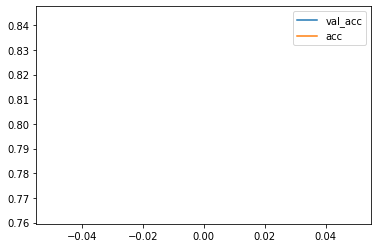

In [ ]:
plt.plot(history.history['val_acc'])
plt.plot(history.history['acc'])
plt.legend(['val_acc', 'acc'])
plt.show()

Epoch 9/10
937/937 [==============================] - 19s 20ms/step - loss: 0.2586 - acc: 0.9083 - val_loss: 0.3769 - val_acc: 0.8701
Epoch 10/10
937/937 [==============================] - 19s 20ms/step - loss: 0.2442 - acc: 0.9132 - val_loss: 0.3713 - val_acc: 0.8733